In [1]:
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt
import ipywidgets
from matplotlib.pyplot import imshow, subplot, title

In [29]:
def fig(w,h):
    return plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread(file), cv.COLOR_BGR2RGB) 

def rgb2yuv(x):
    return cv.cvtColor(x,cv.COLOR_RGB2YUV)

def yuv2rgb(x):
    return cv.cvtColor(x,cv.COLOR_YUV2RGB) 

byte = np.uint8

(675, 1200, 3)


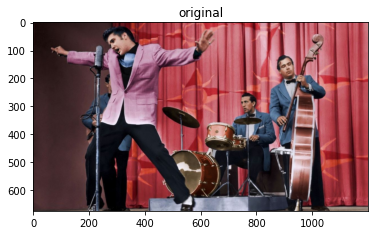

In [5]:
img = readrgb("elvis.jpg")
imshow(img); title('original');
rows,cols,d = img.shape
print(img.shape)

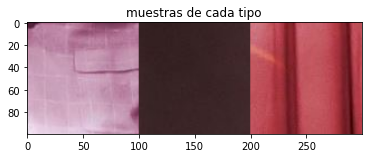

In [14]:
r1 = img[250:350,330:430]
r2 = img[250:350,50:150]
r3 = img[250:350,1050:1150]
models = [r1,r2,r3]

imshow(np.hstack(models)); title('muestras de cada tipo');

Primero vamos a reproducir el modelo simple

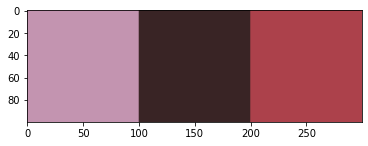

In [19]:
med = [ np.mean(r,(0,1)) for r in models ]

muestras = []
for color in med:
    x = np.zeros([100,100,3],byte)
    x[:,:] = color
    muestras.append(x)

imshow(np.hstack(muestras));

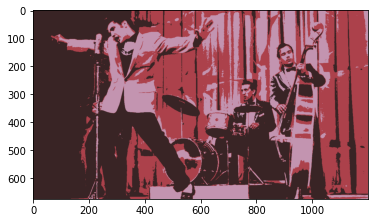

In [25]:
d = [ np.sum(abs(img - m), axis=2) for m in med ]
c  = np.argmin(d, axis=0)
res = np.zeros(img.shape, byte)
for k in range(len(models)):
    res[c==k] = med[k]

imshow(res);

Vemos como necesitaríamos utilizar más colores para reproducir fielmente la imagen original. Pero el resultado obtenido es bastante bonito, y podemos utilizar esta idea para aplicar algunos filtros de colores a las imágenes. Por ejemplo, podríamos hacer algo así:

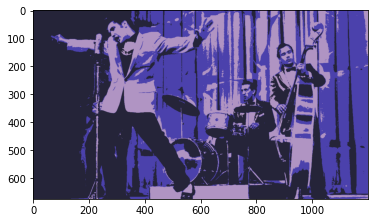

In [21]:
nwIm = res.copy()
nwIm[:,:,0] = res[:,:,2]
nwIm[:,:,2] = res[:,:,0]
imshow(nwIm);

Entonces podríamos tomar, por ejemplo, tres tonos característicos de una imagen. Aplicar la reproyección tal y como hemos hecho, y cambiar los colores en función del resultado buscado. 

Vamos a seguir tal y como se hace en el notebook explicativo.

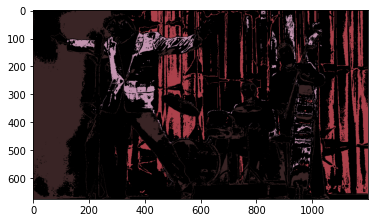

In [22]:
md = np.min(d, axis=0)

res [md > 40] = 0,0,0

imshow(res);

El resultado al hacer esto es muy pobre, ya que la imagen presenta colores muy diversos y hemos elegido una gama estrecha de colores (hemos tomado tres colores rojizos). Esto era esperable. Podemos ajustar el threshold tomado:

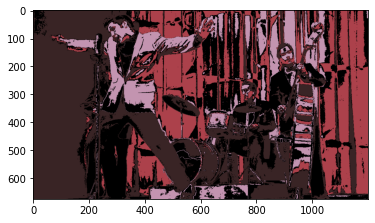

In [26]:
md = np.min(d, axis=0)

res [md > 80] = 0,0,0

imshow(res);

Y ya se distinguen los objetos de la imagen. Además, da un toque de cartoon, que hace que la imagen parezca un dibujo.

Ahora lo hacemos probabilísticamente:

In [27]:


# calcula el histograma (normalizado) de los canales conjuntos UV
def uvh(x):
    
    # normalizar un histograma
    # para tener frecuencias (suman 1)
    # en vez de número de elementos
    def normhist(x): return x / np.sum(x)
    
    yuv = rgb2yuv(x)
    h = cv.calcHist([yuv]     # necesario ponerlo en una lista aunque solo admite un elemento
                    ,[1,2]    # elegimos los canales U y V
                    ,None     # posible máscara
                    ,[32,32]  # las cajitas en cada dimensión
                    ,[0,256]+[0,256] # rango de interés (todo)
                   )
    return normhist(h)



In [30]:
hist = [uvh(r) for r in models]

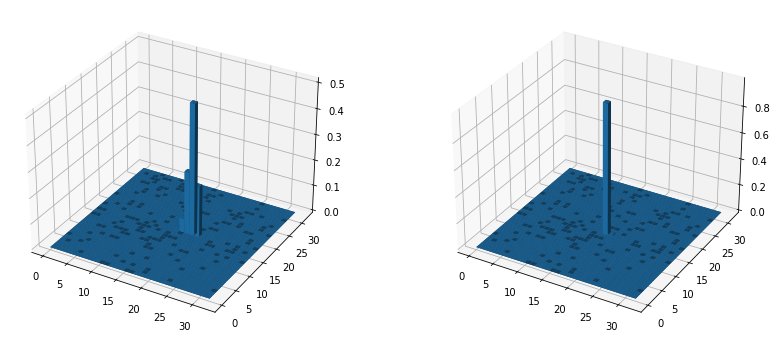

In [31]:
from mpl_toolkits.mplot3d import Axes3D
fg = plt.figure(figsize=(14, 6))

_xx, _yy = np.meshgrid(np.arange(32), np.arange(32))
x, y = _xx.ravel(), _yy.ravel()
bottom = 0
width = depth = 1

ax1 = fg.add_subplot(121, projection='3d')
top = hist[0].ravel()
ax1.bar3d(x, y, bottom, width, depth, top , shade=True);

ax1 = fg.add_subplot(122, projection='3d')
top = hist[1].ravel()
ax1.bar3d(x, y, bottom, width, depth, top, shade=True);

In [32]:
uvr = np.floor_divide( cv.cvtColor(img,cv.COLOR_RGB2YUV)[:,:,[1,2]], 8)
print(uvr.shape, uvr.dtype)

(675, 1200, 2) uint8


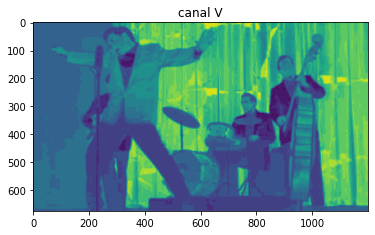

In [33]:
imshow(uvr[:,:,1]); title('canal V');

In [35]:
u = uvr[:,:,0]
v = uvr[:,:,1]

lik = [ h[u,v] for h in hist ]
lik = [ cv.GaussianBlur(l, (0,0), 10) for l in lik ]

C:\Users\Jose\AppData\Local\Temp\ipykernel_4828\937867013.py:2: RuntimeWarning: invalid value encountered in true_divide
  p = np.array(lik) / E


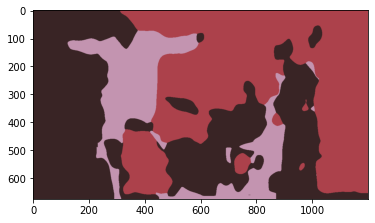

In [36]:
E = np.sum(lik, axis=0)
p = np.array(lik) / E
c  = np.argmax(p,axis=0)
mp = np.max(p, axis=0)
mp[E < 0.1] = 0
res = np.zeros(img.shape,np.uint8)
for k in range(len(models)):
    res[c==k] = med[k]

imshow(res);

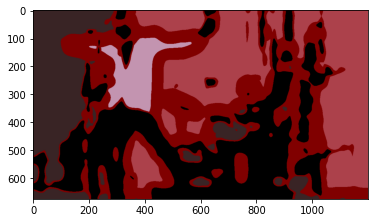

In [37]:
res[mp < 0.99] = 128,0,0
res[E < 0.05] = 0,0,0
imshow(res);

Y obviamente obtenemos una imagen compleja de entender si no conoces la original. Pero se observan algunas de las características principales de la misma. Si usásemos más colores más variados, seguramente los resultados serían considerablemente mejores.